### base functions (make fig & prep data)

In [1]:
import numpy as np
import os
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import tensorflow as tf

'''
make fig
'''
def plot_sol1(X_star, phi1,title):
    lb = X_star.min(0); ub = X_star.max(0)
    x, y = np.linspace(lb[0], ub[0], 200), np.linspace(lb[1], ub[1], 150); x, y = np.meshgrid(x, y)
    PHI_I = griddata(X_star, phi1.flatten(), (x, y), method = "linear")
    plt.figure(figsize = (12, 4))
    plt.imshow(PHI_I, interpolation='nearest',cmap='rainbow', extent=[0,1,-1,1], origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'{title}')
    plt.xlabel('t')
    plt.ylabel('x')
    if not os.path.exists('./pics'):
        os.makedirs('./pics')
    plt.savefig(f'./pics/{title}')

def plot_loss_log(ep_log, loss_log,save_name):
    plt.figure(figsize = (8, 4))
    plt.plot(ep_log, loss_log, alpha = .7, label = "loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.grid(alpha = .5)
    plt.legend(loc = "upper right")
    plt.title('train loss(log)')
    if not os.path.exists('./pics'):
        os.makedirs('./pics')
    plt.savefig(f'./pics/{save_name}')

def plot_loss(ep_log, loss_log,save_name):
    plt.figure(figsize=(8,4))
    fig,ax = plt.subplots(2,1)
    strt = int(len(ep_log)*0.6)
    ax[0].plot(ep_log, loss_log)
    ax[0].grid(alpha=.5)
    ax[0].set_ylabel('loss')
    ax[0].set_title('train loss')
    ax[1].plot(ep_log[strt:], loss_log[strt:])
    ax[1].grid(alpha=.5)
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    if not os.path.exists('./pics'):
        os.makedirs('./pics')
    fig.savefig(f"./pics/{save_name}")

"""
prep data
"""
def func_u0(x):
    return - tf.sin(np.pi * x)

def func_ub(x):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype = tf.float32)

def prp_grd(tmin, tmax, nt,
            xmin, xmax, nx):
    t = np.linspace(tmin, tmax, nt)
    x = np.linspace(xmin, xmax, nx)
    t, x = np.meshgrid(t, x)
    t, x = t.reshape(-1, 1), x.reshape(-1, 1)
    TX = np.c_[t, x]
    return t, x, TX

def prp_dataset(tmin, tmax, xmin, xmax, N_0, N_b, N_r):
    lb = tf.constant([tmin, xmin], dtype = tf.float32)
    ub = tf.constant([tmax, xmax], dtype = tf.float32)
    t_0 = tf.ones((N_0, 1), dtype = tf.float32) * lb[0]
    x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype = tf.float32)
    t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = tf.float32)
    x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), .5, dtype = tf.float32)
    t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
    x_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = tf.float32)

    return t_0, x_0, t_b, x_b, t_r, x_r

### PINNs model

In [2]:
import os
import time
import datetime
import tensorflow as tf
import numpy as np

class PINN(tf.keras.Model):
    def __init__(self, 
                 t_0, x_0, u_0, 
                 t_b, x_b, u_b, 
                 t_f, x_f, 
                 in_dim, out_dim, width, depth, activ = "tanh", 
                 w_init = "glorot_normal", b_init = "zeros", 
                 lr = 1e-3, opt = "Adam",
                 freq_info = 500, r_seed = 1234):
        # initialize the configuration
        super().__init__()
        self.r_seed = r_seed
        self.random_seed(seed = r_seed)
        self.data_type  = tf.float32
        self.in_dim     = in_dim       # input dimension
        self.out_dim     = out_dim       # output dimension
        self.width     = width       # internal dimension
        self.depth  = depth    # (# of hidden layers) + output layer
        self.activ  = activ    # activation function
        self.w_init = w_init   # initial weight
        self.b_init = b_init   # initial bias
        self.lr     = lr       # learning rate
        self.opt    = opt      # name of your optimizer
        self.freq_info = freq_info    # monitoring frequency

        # input-output pair
        self.t_0 = t_0; self.x_0 = x_0; self.u_0 = u_0   # evaluates initial condition
        self.t_b = t_b; self.x_b = x_b; self.u_b = u_b   # evaluates boundary condition
        self.t_f = t_f; self.x_f = x_f                   # evaluates domain residual
        
        # bounds
        X_r     = tf.concat([t_f, x_f], 1)
        self.lb = tf.cast(tf.reduce_min(X_r, axis = 0), self.data_type)
        self.ub = tf.cast(tf.reduce_max(X_r, axis = 0), self.data_type)
        
        # call
        self.dnn = self.dnn_init(in_dim, out_dim, width, depth)
        self.params = self.dnn.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        
        # parameter setting
        self.nu = tf.constant(.01 / np.pi, dtype = self.data_type)

        # track loss
        self.ep_log = []
        self.loss_log = []
        
        print("\n************************************************************")
        print("****************     MAIN PROGRAM START     ****************")
        print("************************************************************")
        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
        
    def random_seed(self, seed = 1234):
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
    def dnn_init(self, in_dim, out_dim, width, depth):
        # network configuration (N: in_dim -> out_dim (in_dim -> width -> ... -> width -> out_dim))
        network = tf.keras.Sequential()
        network.add(tf.keras.layers.InputLayer(in_dim))
        network.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        # construct the network
        for l in range(depth - 1):
            network.add(tf.keras.layers.Dense(width, activation = self.activ, use_bias = True,
                                                kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                                                kernel_regularizer = None, bias_regularizer = None, 
                                                activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
        network.add(tf.keras.layers.Dense(out_dim))
        return network
    
    def PDE(self, t, x):
        t = tf.convert_to_tensor(t, dtype = self.data_type)
        x = tf.convert_to_tensor(x, dtype = self.data_type)
        with tf.GradientTape(persistent = True) as tp:
            tp.watch(t)
            tp.watch(x)
            u = self.dnn(tf.concat([t, x], 1))
            u_x = tp.gradient(u, x)
        u_t  = tp.gradient(u, t)
        u_xx = tp.gradient(u_x, x)
        del tp
        f = u_t + u * u_x - self.nu * u_xx
        return u, f

    @tf.function
    def loss_glb(self, 
                 t_0, x_0, u_0, 
                 t_b, x_b, u_b, 
                 t_f, x_f):
        loss_0_u_hat,loss_0_f = self.PDE(t_0, x_0)
        loss_b_u_hat,loss_b_f = self.PDE(t_b, x_b)
        f = self.PDE(t_f,x_f)
        loss_0 = tf.reduce_mean(tf.square(u_0 - loss_0_u_hat))
        loss_b = tf.reduce_mean(tf.square(u_b - loss_b_u_hat))
        loss_f = tf.reduce_mean(tf.square(f))
        loss_glb = loss_0 + loss_b + loss_f
        return loss_glb

    def loss_grad(self, 
                  t_0, x_0, u_0, 
                  t_b, x_b, u_b, 
                  t_f, x_f): 
        with tf.GradientTape(persistent = True) as tp:
            loss = self.loss_glb(t_0, x_0, u_0, 
                                 t_b, x_b, u_b, 
                                 t_f, x_f)
        grad = tp.gradient(loss, self.params)
        del tp
        return loss, grad
    
    @tf.function
    def grad_desc(self, 
                  t_0, x_0, u_0, 
                  t_b, x_b, u_b, 
                  t_f, x_f):
        loss, grad = self.loss_grad(t_0, x_0, u_0, 
                                    t_b, x_b, u_b, 
                                    t_f, x_f)
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss
        
    def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         batch size     :", batch)
        print("         convergence tol:", tol)
        
        t0 = time.time()
        
        # I had to convert input data (tf.tensor) into numpy style in order for mini-batch training (slicing)
        # and this works well for both full-batch and mini-batch training
        t_0 = self.t_0.numpy(); x_0 = self.x_0.numpy(); u_0 = self.u_0.numpy()
        t_b = self.t_b.numpy(); x_b = self.x_b.numpy(); u_b = self.u_b.numpy()
        t_f = self.t_f.numpy(); x_f = self.x_f.numpy()
        
        for ep in range(epoch):
            ep_loss = 0
            n_r = self.x_f.shape[0]
            idx_f = np.random.permutation(n_r)
            for idx in range(0, n_r, batch):
                # batch for domain residual
                t_f_btch = tf.convert_to_tensor(t_f[idx_f[idx: idx + batch if idx + batch < n_r else n_r]], dtype = self.data_type)
                x_f_btch = tf.convert_to_tensor(x_f[idx_f[idx: idx + batch if idx + batch < n_r else n_r]], dtype = self.data_type)
                # compute loss and perform gradient descent
                loss_btch = self.grad_desc(t_0, x_0, u_0, 
                                            t_b, x_b, u_b, 
                                            t_f_btch, x_f_btch)
                ep_loss += loss_btch / int(n_r / batch)
                
            if ep % self.freq_info == 0:
                elps = time.time() - t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            
            if ep_loss < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
        
        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())
                
    def predict(self, t, x):
        u_hat, f = self.PDE(t, x)
        return u_hat, f


### burgers equation

lower bound tf.Tensor([ 0. -1.], shape=(2,), dtype=float32)
upper bound tf.Tensor([1. 1.], shape=(2,), dtype=float32)

************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2022-07-06 17:10:12.256515
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x000001DA4776A1C0>
         optimizer    : Adam
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 20)                60        
                          

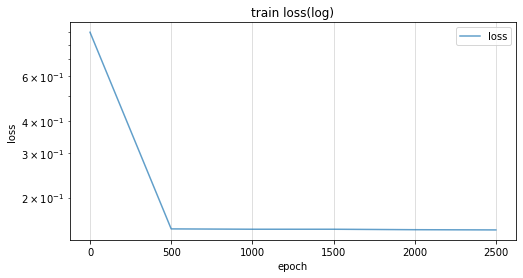

<Figure size 576x288 with 0 Axes>

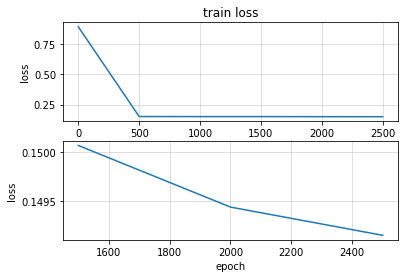

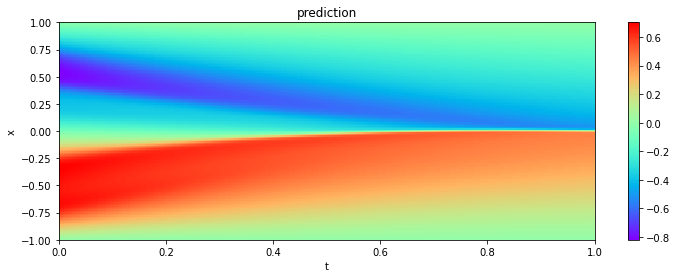

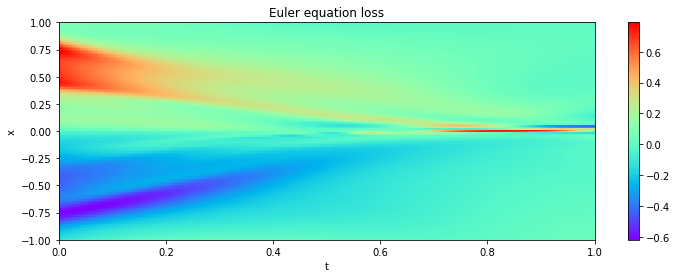

In [3]:
import time
import numpy as np
import tensorflow as tf

def main():
    tmin, tmax =  0., 1.
    xmin, xmax = -1., 1.
    N_0 = 60
    N_b = 60
    N_r = 1500

    epoch = 3000
    batch = 2**8
    tol = 1e-8

    lr0 = 5e-3
    gam = 1e-2
    lrd_cos = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate = lr0, 
        decay_steps = epoch, 
        alpha = gam
        )
    lr = lrd_cos

    t_0, x_0, t_b, x_b, t_r, x_r = prp_dataset(tmin, tmax, xmin, xmax, N_0, N_b, N_r)
    u_0 = func_u0(x_0)
    u_b = func_ub(x_b)

    pinn = PINN(t_0, x_0, u_0, 
                t_b, x_b, u_b, 
                t_r, x_r, 
                in_dim = 2, out_dim=1, width=20, depth=8, activ = "tanh",
                w_init = "glorot_normal", b_init = "zeros", 
                lr = lr, opt = "Adam")

    # if os.path.exists('./burgers_saved_model'):
    #     # 只保留模型dnn，pinn中的其他都未保存
    #     print('load the previous model')
    #     pinn.dnn = tf.saved_model.load('./burgers_saved_model')
    # else:
    pinn.train(epoch, batch, tol)
    plot_loss_log(pinn.ep_log,pinn.loss_log,'train_loss_log')
    plot_loss(pinn.ep_log,pinn.loss_log,'train_loss')
        
    # PINN inference
    nt = int(1e3) + 1
    nx = int(1e2) + 1
    t, x, TX = prp_grd(
        tmin, tmax, nt, 
        xmin, xmax, nx
    )
    t0 = time.time()
    u_hat, f = pinn.predict(t, x)
    t1 = time.time()
    elps = t1 - t0
    print("elapsed time for PINN inference (sec):", elps)
    print("elapsed time for PINN inference (min):", elps / 60.)
    plot_sol1(TX, u_hat.numpy(),title='prediction')
    plot_sol1(TX, f.numpy(),title='Euler equation loss')

    # pinn.dnn.save("burgers_saved_model")

if __name__ == "__main__":
    main()
